# MILESTONE 2

In [29]:
#Imports
import re
import pandas as pd
import string 
import pickle
import os
import codecs
import io
import numpy as np
from datetime import datetime 
import datetime as dt
import json
import time
import numpy
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import random
from functools import reduce

#Error message if an import fails
some_failed=False

try:
    from textblob import TextBlob
except:
    !conda install -y -v -c conda-forge textblob
    some_failed=True
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import TweetTokenizer
except:
    !conda install -y -v -c conda-forge nltk
    some_failed=True
try:
    import gensim
    from gensim import corpora
except:
    !conda install -y -v -c anaconda gensim
    some_failed=True
try:
    from googletrans import Translator
except:
    !pip install googletrans
    some_failed=True
try: 
    import tweepy
    from tweepy import OAuthHandler
except:
    !conda install -y -v -c conda-forge tweepy 
    some_failed=True
try:
    from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
except:
    !conda install -y -v -c https://conda.anaconda.org/amueller wordcloud
    some_failed=True

if(some_failed):
    print('restarted kernel with dependencies installed, please run cell again')
    os._exit(00)
    
%matplotlib inline

In [30]:
#Constants
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

To start processing and working with the dataset, we have focused in only one protest, #BlackLivesMatter. For this purpose we obtain all tweets in the dataset with this hashtag, which normally would represent the people in favour. As people against don't normally use this hashtag, because its use is a measure of the impact and success of the protest, we also filter by hashtags considered against this protest and supporting the police: #AllLivesMatter, #BlueLivesMatter, #AllLivesMatter, #WhiteLivesMattter, #NYPDLivesMatter and  #PoliceLivesMatter. Throughtout this notebook we will refer to those hashtags against #BlackLivesMatter as  #AllLivesMatter, as it's the most extended. This way, we have tweets from both in favour and against the protest and we can observe the trends and tendencies in each. 

The rest of this notebook is organized as follows. We have divided it in sections, depending on which analysis we are performing in each part and what the functions do. Thus, we have the following sections:
* Process raw tweets: for processing the tweets read from the database and adding them to a dataframe
* Initial analysis: small analysis to get an idea of the data
* Language: analysis of the different languages of the tweets
* Topics modelling: function for obtaining the different topics discussed on the tweets so we can observe how they tend to change over time and what is discussed
* Sentiment analysis: functions performing sentiment analysis of the tweets that allow us to study the polarity and subjectivity
* Using the API: functions querying the Twitter API to obtain more information about the tweets, such as the number of retweets, number of followers of the people that tweitted and location. 

__These sections mostly define helper functions that will help us analyse the data for the next milestone and observe the trends.__

***

## Process raw tweets

** Format of the tweets **

The raw tweets obtained from the database have the following format: 

| 2 characters | 18 characters   | weekday month day  HH:MM:SS time_zone year| user | *optional* | text
|:----:|:----:|:----:|:----:|:----:|:----:
|   language id  | tweet id | date | username | (RT) | text


The first two characters indicate the language of the tweet. Next is the 64 bit (18 characters) ID of the tweet. In the next field we can find the date, showing first weekday, followed by month, day of the month, hour , the time zone and finally the year. We can then find the tag *RT* if is a retweet. Finally, we have the tweet itself.

**Reading**

We create a function *read_tweet_files* for reading the tweets filtered by hashtag from the database. This function takes the hashtag used for filtering (to identify the file) and returns a list with one tweet per line.

In [31]:
def read_tweet_files(hashtag):
    '''
    Read tweets from the txt file gotten from cluster
    INPUT:
        hashtag: hashtags for which we have data
    OUTPUT:
        tweets_list,hashtag:list of tweets in file, hashtag searched for 
    '''
    
    tweets_list=[]
    #path
    file_name='../tweets_datasets_cluster/tweets'
    #name of file depending on the hashtag
    if hashtag=='#blacklivesmatter':
        file_name+='_blm'
    elif hashtag=='#alllivesmatter':
        file_name+='_against_blm'
    else:
        return [],hashtag
    file_name+='.txt'
    
    #read file
    with io.open(file_name,'r',encoding='utf-8') as file:
        for line in file:
            if(':') in line:
                line=line.replace('\\t','\t')
                tweet_text=line.split(':',maxsplit=1)[1][:-2]
                tweets_list.append(tweet_text)
    return tweets_list,hashtag


To process these tweets in raw format we create the function *process_tweets* which given the list of tweets obtain from the MapReduce jobs, returns a dataframe which the tweets divided by their fields, that is with the columns:
   * lang: language of the tweet
   * id: id of the tweet, converted to int
   * date: with the format year/month/day
   * epoch: timestamp aggregated by day
   * user: who tweeted
   * text: of the tweet
   
In addition, we also show add a column with the hashtags found in the tweets, the hashtag used in the filtering, and if it's a retweet the handle of the user who first tweeted:
   * hashes_inside: hashtags found in the tweets
   * hashtag: hashtag as filter to obtain the tweet
   * to: retweet handles inside the tweet

In [32]:

def process_tweets(tweet_list,hashtag):
    '''
    Process tweets from the database dividing them by their fields
    INPUT:
        tweet_list: tweet as returned by the databasee
    OUTPUT:
        dataframe with one row per tweet and columns
            -lang: language of the tweet
            -id: id of the tweet
            -date: with the format year/month/day
            -epoch: timestamp of the tweet aggregated by day
            -user: who tweeted
            -text: of the tweet
            -hashtag:which tweet definitely contains
            -hashes_inside: hashtags in the text
            -to:retweet handles inside tweet 
    '''
    
    #Dictionary for storing intermediate values
    d={'lang':[], 'id':[],'date':[], 'epoch':[], 'user':[], 'text':[],'hashtag':[],'hashes_inside':[],'to':[]}
    #Iterate through every tweet in the list
    for i,tweet in enumerate(tweet_list):
        #Initalize values
        lang,id_,day,month,year,epoch,user,to,hashes_in,text,dt='en','-1','-1','-1','-1','-1','-1','-1','-1','-1','-1'
        try:
            #Split them by spaces
            token=re.split('\s+', tweet)
            #Language
            lang=token[0]
            #Tweet id
            id_=int(token[1])
            #Date
            day=token[4]
            month=token[3]
            year=token[7]
            dt = datetime.strptime(year+' '+month+' '+day, '%Y %b %d')
            epoch=time.mktime(dt.timetuple())
            #user who tweeted
            user=token[8]
            #Language
            lang=token[0]
            
            #Text: join the tokenized words separating them with spaces
            text=" ".join(token[9:])
            hashes_in='' #hashtags in text
            to='' #user mentions
            
            #for each word in the text
            for token in token[9:]:
                #If it's a hasthag we add it to the list
                if token[0]=='#':
                    hashes_in=hashes_in+' '+token
                #If it's a retweet, get the handles of the user who tweeted it 
                elif token[0]=='@':
                    to_add=token
                    if(to_add[-1])==':':
                        to_add=to_add[:-1]
                    to=to+' '+to_add
        
        #If missing field, ignore tweet
        except:
            continue
        
        #Language
        d['lang'].append(lang[1:])
        #ID
        d['id'].append(id_)
        
        #Date
        d['epoch'].append(epoch)
        d['date'].append(dt)
        #Username
        d['user'].append(user)
        #Text
        d['text'].append(text)
        d['hashtag'].append(hashtag)
        d['hashes_inside'].append(hashes_in)
        d['to'].append(to)
    #Create dataframe from the dictionary and set the id as the index
    df=pd.DataFrame.from_dict(d).set_index('id')
    df['date']=pd.to_datetime(df['date'])
    return df



## Initial analysis 

In this section, we read the tweets using the functions defined above and do a small analysis to observe the distribution of the data. We perform it for #BlackLivesMatter, in favour 

We obtain all tweets from the database containing the hashtag #BlackLivesMatter or variations with different capitalized letters by filtering by this hashtag in the text. These tweets range from 28th August 2013 to 31st January 2016, the last day captured in the database. There are 243353 tweets, written by 143920 different users, that is, 59% of the tweets are written by different people. They are written in 6 differents languages (german, english, spanish, french, italian, dutch).

In [33]:
#Read the tweets
tweet_blm=process_tweets(*read_tweet_files('#blacklivesmatter'))
tweet_blm.sort_values(by='date', inplace =True) #Sort by date

In [34]:
#Small analysis of data
n_blm=len(tweet_blm)
print('Number of #BlackLivesMatter tweets: ', n_blm)
print('Tweets from {} to {}'.format(tweet_blm['date'].iloc[0], tweet_blm['date'].iloc[-1]))
print('Number of different users tweeting: {},  {}% of the total'.format(len(np.unique(tweet_blm['user'])), 
                                                                        len(np.unique(tweet_blm['user']))/n_blm))
print('Tweets written in {} languages: {}'. format(len(np.unique(tweet_blm.lang)),  np.unique(tweet_blm.lang)))

tweet_blm.head()

Number of #BlackLivesMatter tweets:  243353
Tweets from 2013-07-16 00:00:00 to 2016-01-31 00:00:00
Number of different users tweeting: 143920,  0.591404256368321% of the total
Tweets written in 6 languages: ['de' 'en' 'es' 'fr' 'it' 'nl']


,date,epoch,hashes_inside,hashtag,lang,text,to,user
id,,,,,,,,
357220558867410945,2013-07-16,1.373926e+09,"#blacklivesmatter""",#blacklivesmatter,en,"Led by Kenneth Harding Jr's mother, activists ...",,juliacarriew
356945513100230657,2013-07-16,1.373926e+09,"#blacklivesmatter""",#blacklivesmatter,en,"@Aaronaod #blacklivesmatter""",@Aaronaod,KINGDACEO
357415765999235072,2013-07-17,1.374012e+09,"#blacklivesmatter""",#blacklivesmatter,en,"I'm a day late, but happy belated birthday to ...",,AndriBica85
357645160827469824,2013-07-17,1.374012e+09,"#J4TMLA #blacklivesmatter""",#blacklivesmatter,en,Mama Brigade on the way to mass demo for Trayv...,,DocMellyMel
357573836692135936,2013-07-17,1.374012e+09,"#BlackLivesMatter #JusticeForTrayvon""",#blacklivesmatter,en,VIDEO: 100 Young Black Activists Respond to Ge...,,opalayo


We also obtain all tweets from others hashtags suchs as #AllLivesMatter, #BlueLivesMatter, #AllLivesMatter, #WhiteLivesMattter, #NYPDLivesMatter and  #PoliceLivesMatter, normally considered against the #BlackLivesMatter protest. In this case, we can observe that the tweets start sparsely in 2012. It can be observed than in the first tweets both the #AllLivesMatter and the #BlackLivesMatter hashtag are, which seems to indicate that both hashtags were initally used by supporters of the protest too and probably evolved over time. 

There are only 89467 tweets from these hashtags, approximately 64% less than from #BlackLivesMatter. However, 65% are from different people, which seems to indicate that they were slightly less engaged than in favour of the protest. These tweets are also written in the same six languages as #BlackLivesMatter tweets.

In [16]:
#Read police supporters tweets
tweet_alllm=process_tweets(*read_tweet_files('#alllivesmatter'))
tweet_alllm.sort_values(by='date', inplace =True) #Sort by date

In [17]:
#Small analysis of data
n_alllm=len(tweet_alllm)
print('Number of #AllLivesMatter tweets: ', n_alllm)
print('Tweets from {} to {}'.format(tweet_alllm['date'].iloc[0], tweet_alllm['date'].iloc[-1]))
print('Number of different users tweeting: {},  {}% of the total'.format(len(np.unique(tweet_alllm['user'])), 
                                                                        len(np.unique(tweet_alllm['user']))/n_alllm))
print('Tweets written in {} languages: {}'. format(len(np.unique(tweet_alllm.lang)),  np.unique(tweet_alllm.lang)))

tweet_alllm.head()

Number of #AllLivesMatter tweets:  89467
Tweets from 2012-07-25 00:00:00 to 2016-01-31 00:00:00
Number of different users tweeting: 58973,  0.6591592430728649% of the total
Tweets written in 6 languages: ['de' 'en' 'es' 'fr' 'it' 'nl']


,date,epoch,hashes_inside,hashtag,lang,text,to,user
id,,,,,,,,
228069810024615937,2012-07-25,1.343167e+09,"#alllivesmatter""",#alllivesmatter,de,"Thank you @bomberscat #alllivesmatter""",@bomberscat,liviamutic
238998664905891840,2012-08-24,1.345759e+09,"#alllivesmatter""",#alllivesmatter,en,@jessespector would you have cared this much i...,@jessespector,robertaguilarjr
356241167899295747,2013-07-14,1.373753e+09,"#AllLivesMatter""",#alllivesmatter,en,"RT @aripiphany: #AllLivesMatter""",@aripiphany,TheRealBenj5
434866588274008064,2014-02-16,1.392505e+09,#BlackLivesMatter #AllLivesMatter,#alllivesmatter,en,"\""@GoodofMichael: #BlackLivesMatter and #AllLi...",,WGSwagg
434864348456964096,2014-02-16,1.392505e+09,#BlackLivesMatter #AllLivesMatter,#alllivesmatter,en,#BlackLivesMatter and #AllLivesMatter we are a...,,GoodofMichael


**Distribution of the number of tweets over time**

Next we explore how the tweets relating to this protest are distributed over time. Even though they start in 2013 their frequency is too small to be taken into account, so we plot the number of tweets starting in May 2014. We aggregate the data by day to try and relate peaks in the plot to concrete events.

We can observe a few #BlackLivesMatter tweets in August and September 2014, which coincide with the violent protests in Ferguson which started to make the movement known worlwide. However, is not until December where the number of tweets exploded. On December 3th, a grand jury decides not to judge a police for the killing of Eric Gardner. This resulted in huge protests around New York and on the 9th December, Lebron James, Kobe Bryant and the LA Lakers wears an #ICan'tBreathe shirt, hashtag that was used to refer to Eric Gardner's death. Protests continued on the following days and more media coverage was given to the protest resulting in the high amount of tweets. It should be noted that around the 8th of January, when Essence magazine dedicated their cover to #BlackLivesMatter, the amount of tweets agains this hashtag is even bigger than in favour. The plot shows that after January, although the number of tweets for #BlackLivesMatter was greatly reduced, the hashtag was still used and the protest was still alive, with increments again when some protest happened. Likewise, #AllLivesMatter and the other tweets have a few tweets, without disappearing completely and smaller rises. For example, the peak in May 2014 is caused by massive protests in Baltimore after the kill of yet another black person unarmed. Similarly, the 5th and 6th of July two black people were killed and on the 7th five police officers were shot during a protest. It is interesting, how this shooting of policeman did not incite a rise on the tweets supporting the police as could be expected.

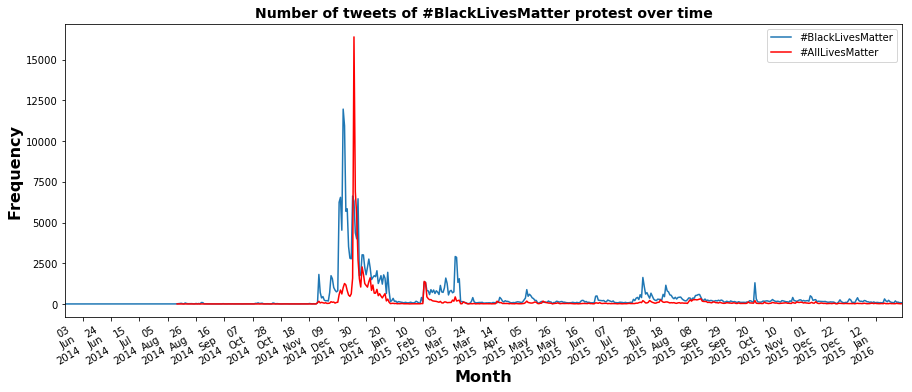

In [41]:
#Plot the number of tweets from 2014-05-16 (show the peak better)
#BLM
ax=tweet_blm[tweet_blm['date']>'2014-05-16'].groupby('date').epoch.agg('count').plot(kind='line', 
                                                                                     figsize=[15,6], 
                                                                                     label='#BlackLivesMatter',
                                                                                     legend=True)
#ALM
tweet_alllm[tweet_alllm['date']>'2014-05-16'].groupby('date').epoch.agg('count').plot(ax=ax, 
                                                                                      kind='line', 
                                                                                      label='#AllLivesMatter',
                                                                                      legend=True,
                                                                                      style='r-',
                                                                                      )
#Labels
ax.set_title('Number of tweets of #BlackLivesMatter protest over time',fontsize=14, fontweight='bold') #Title
ax.set_xlabel('Month',fontsize=16, fontweight='bold') #xlabel
ax.set_ylabel('Frequency',fontsize=16, fontweight='bold') #ylabel
#Change ticks parameters
ax.tick_params(labelsize=10) #Size
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=3)) #Position
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%b\n%Y')) #Format

** Aparition of hashtags against and in favour together **

We analyse the aparition of hashtags that are considered supportive (#BlackLivesMatter) and against (#AllLiveMatters, #PoliceLivesMatter, etc.) of the protest together, to understand whether this hashtags were not as polarized (in favour or against) as it is normally thought or whether this polarization grew over time.

First, we obtain which of the hashtags of against #BlackLivesMatter where used with this hashtag by looking in the *hashes_inside* column for the other hashtags and adding them to a new column called *other_tag* in a new dataframe called *cooc_tags*.

In [16]:
#Co-occurences

#Tags against #BlackLiveMatters
antitags=['#AllLivesMatter,' '#BlueLivesMatter', '#AllLivesMatter', '#WhiteLivesMattter', 
          '#NYPDLivesMatter', '#PoliceLivesMatter']

#Copy dataframe adding a column for the other tag found
cooc_tags=tweet_blm.copy()
cooc_tags["other_tag"] = np.nan
#For each tag, mark the tweets where we find the hashatg with it
for tag in antitags: 
    #Put tag as other_tag for the tweets were tag in the other hashes, without being case sensitive.
    cooc_tags.loc[tweet_blm['hashes_inside'].str.contains(tag,case=False), 'other_tag']=tag
#Drop rows without any of the antitags in the text
cooc_tags=cooc_tags.dropna()

Then, we plot the number of tweets with both a hashtag for and against the protests in a bar plot, aggregated by month. Our first observation is that the only three hashtags against the protest used in conjunction with #BlackLivesMatter: #AllLivesMatter, #PoliceLivesMatter and #NYPDLivesMatter. With a naive analysis (that it, not considering the total number of tweets from each of the hashtags) it seems that at first, all three of the hashtags were used together with #BlackLivesMatter, which means that they were used regardless of supporting or not the protest. However, as time passes it seems that only #AllLivesMatter is still used by both groups. Thus, we conclude that this tweet is probably not so polarized as the others.

For next milestone, we are planning on also showing the number of tweets of each hashtag in each of the months to see if it's a significant percentage.

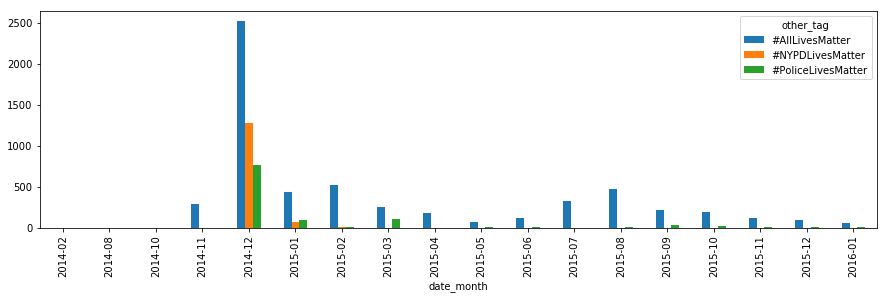

In [40]:
#Group the dates by month
cooc_tags['date_month']=cooc_tags.date.dt.to_period("M")

#Bar plot aggregated by month and tag
cooc_tags.groupby(['date_month', 'other_tag']).size().unstack().plot(kind='bar', stacked=False,  figsize=[15,4])


** Hashtags wordcloud **

We generate a wordcloud which allows us to observe the most repeated keywords in the tweets supporting and against the protest. We define two functions, one for generaring the gray color function, *grey_color_func* and another for generating the wordcloud *generate_wordcloud*. We generate the wordcloud passing it a mask, a list of stopwords to ignore and all the text from the tweets concatenated in one string separating them by spaces.

In [16]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def generate_wordcloud(text,heading,hcmask):
    '''
    Generate wordcloud
    INPUT:
        text: to generate wordcloud with most frequent words
        heading: title for the plot
        hcmask: mask to construct the image. In white parts appears the wordcloud
    OUTPUT:
        plot
    '''
    #Generate wordcloud: initilize with stopwords and mask and generate the wordcloud with the text
    wordcloud = WordCloud(max_words=2000, mask=hcmask, stopwords=stopwords, margin=10).generate(text)
    
    #Create plot and add title
    plot=plt.figure(figsize=(16,13))
    plt.title(heading)
    
    #Show wordcloud
    plt.imshow(wordcloud.recolor(color_func=grey_color_func,random_state=24),interpolation='bilinear')
   
    plt.axis("off")
    return plot

We load the a different mask for the tweets supporting #BlackLivesMatter and against it, generating a different wordcloud for each. We use the list of stopwords defined by WordCloud by default, adding also *https*, *co* and *RT* to avoid putting URLs or the retweet tag in the wordcloud.

As a result, we can observe that for #BlackLivesMatter the most repeated words are hashtags:  variations of #BlackLiveMatter, in addition to #Ferguson and #ICantBreathe, very extended as well in the protest. We can also find the hashtag #AllLivesMatter, which seems to support our idea that this hashtag is used by both sides of the protest. Among the other words, one can find protest, killed, police and names of the victims.

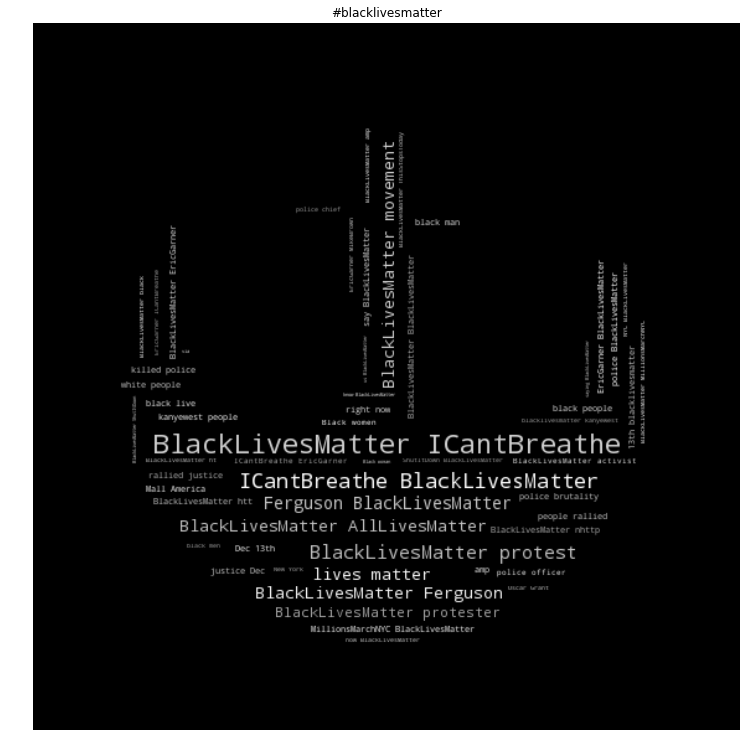

In [17]:
#We load the image for BLM
img2 = imread("halcon.jpg")
hcmask_blm = img2

#We load the image for ALM
img1 = imread("stormtrooper_mask.png")
hcmask_alllm=img1

#load stopwords and add our our own exceptions
stopwords = set(STOPWORDS)
stopwords.add('https') #add https
stopwords.add('co') #add co
stopwords.add('RT') #add RT
#Wordcloud for #BlackLivesMatter: we concatenate all tweets and pass it the title and mask
plot=generate_wordcloud('\n'.join(list(tweet_blm['text'].values)),'#blacklivesmatter', hcmask_blm)

With #AllLivesMatter hashtags one can find all the hastags used tipically in this protest: #AllLivesMatter, #BlueLivesMatter, #AllLivesMatter, #WhiteLivesMattter, #NYPDLivesMatter and  #PoliceLivesMatter. In ths case, instead of the names of victims, one can find names of offices. 

It should be mentioned that the hashtag #BlackLivesMatter appears several times.

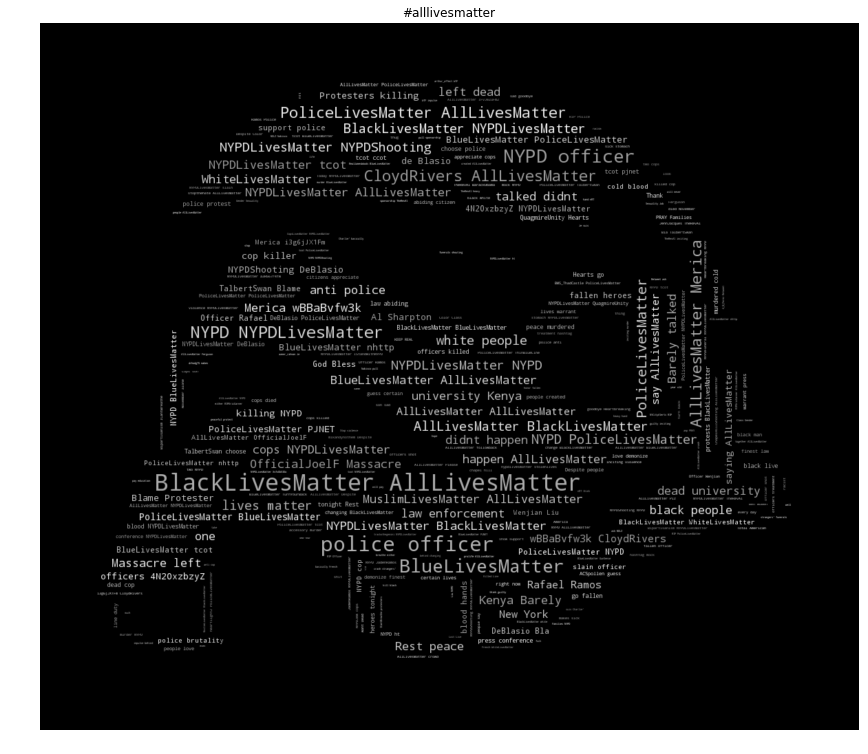

In [18]:
#Wordcloud for #AllLivesMatter
plot2=generate_wordcloud('\n'.join(list(tweet_alllm['text'].values)),'#alllivesmatter',  hcmask_alllm)

In [33]:
regex = re.compile('[.?"\'!*,”…]')
hashes_=list(tweet_blm.hashes_inside.values)
#hashes_=hashes_[:100]
graph_nodes = reduce(lambda x,y:x+y,map(lambda x:regex.sub('',x.lower()).split(),hashes_))
graph_nodes_set_black=set(graph_nodes)

KeyboardInterrupt: 

In [ ]:
hashes_=list(tweet_alllm.hashes_inside.values)
graph_nodes = reduce(lambda x,y:x+y,map(lambda x:regex.sub('',x.lower()).split(),hashes_))
graph_nodes_set_all=set(graph_nodes)

***
## Language 

For a first analysis of the language we can find in our datase we define the function *lang_analysis* which returns the number and percentage of the tweets in each language. In addition, it also prints 3 randomly chosen tweets.

First, we analyse the languages found with the #BlackLivesMatter hashtag. We can find 6 different languages: german (de), english (en), spanish(es), french (fr), italian (it) and dutch (nl). However, more than 97% of the tweets are in english and it can be observed that in the other languages a lot of the tweets are just made of hashtags (probably by a bot) or are written in english. It should also be mentioned that a lot are retweets.

In [29]:
def lang_analysis(df):
    
    lang_count=[]
    #Repeat analysis for all languages
    for lang in np.unique(df.lang):
        tweets_lang=df.loc[df['lang'] == lang]
        #Print the number of tweets
        print(style.BOLD)
        print('Number of tweets in {}: {}, {}%'.format(lang, len(tweets_lang), len(tweets_lang)/len(df)))
        print(style.END) 
        #Print 3 random tweets of each language
        print('\n'.join(np.random.choice(tweets_lang.text.values,3)))
        #Print horizontal line
        print('.'*130)
        lang_count.append(len(tweets_lang)/len(df))
    return lang_count

#BlackLivesMatter language analysis
print(style.BOLD)
print('#BlackLivesMatter')
print(style.END) 

lang_blm=lang_analysis(tweet_blm)




#BlackLivesMatter


Number of tweets in de: 2514, 0.010330671904599492%

RT @prettybrownE86: Great point!! #BlackLivesMatter http://t.co/0A46h3zuoe"
RT @tmi4gg: I Can't Breathe! Ben Franklin Die-In #BlackLivesMatter http://t.co/4i8sbRHUy7"
I see U. 'Study-In Demonstration at Richter Library' on Vimeo http://t.co/QYUE6TDm4h #Vimeo #blacklivesmatter #study-in #protest"
..................................................................................................................................

Number of tweets in en: 236900, 0.9734829650754254%

RT @iAmQueenRo: how? aren't we the ones on the front lines of #BlackLivesMatter? yes we are.. getting arrested and maced but ok https://t.c…"
An eye for an eye it seems. But i am sure his \"tears\" were just for the camera. #ripericgarner #BlackLivesMatter http://t.co/T1YeASjs5Y"
#PoliceLivesMatter #policenews #AllLivesMatter #BlackLivesMatter #LaquanMcDonald IT WAS A FED NOT @Chicago_Police https://t.co/lhBVzJWXm4"
........................

With #AllLivesMatter, we find the same languages and trends as before, with a 95% of tweets in english and the rest mostly are in english or composed only of hashtags. 

In [30]:
#AllLivesMatter
print(style.BOLD)
print('#AllLivesMatter')
print(style.END) 
lang_alllm=lang_analysis(tweet_alllm)


#AllLivesMatter


Number of tweets in de: 684, 0.019495510902094913%

RT @BMS_ThadCastle: #PoliceLivesMatter #AllLivesMatter http://t.co/IFvJeZuFm2"
RT @Chris_1791: #HandsUpDontAbort #HandsUpDontShoot #AllLivesMatter #Ferguson #WombLifeMatters http://t.co/Eq7A4DfJGT"
RT @yungcarl0s: #AllLivesMatter"
..................................................................................................................................

Number of tweets in en: 33709, 0.9607809605244406%

RT @OfficialJoelF: Massacre left 147 dead at a university in Kenya. Barely talked about because it didnt happen here. #AllLivesMatter http:…"
RT @Shaughn_A: #MakeAMovieSmarter \\n\\nThe Wishing Yell \\n\\n#BlackLivesMatter #bluelivesmatter #WhiteLivesMatter #AllLivesMatter http://t.co/zZS…"
RT @frankcalifano: At the end of the day, #AllLivesMatter"
..................................................................................................................................

Number of tweets in es: 182, 0.

Even though the percentage of non-english tweets is very low, we still believe it may be important for obtaining the topics. Thus, we implement a function *translate* which translates a tweet into the given language. This translatation uses the API from googletrans. Given the percentage of tweets incorrectly tagged with another language when they are really in english, we find in which language is the tweet written and only translate the tweets that are not in english. It should also be mentioned that hashtags are not translated.

In [31]:

def translate(tweet, lang_id):
    '''
    Translate a given tweet to lang_id
    INPUT:
        tweet: text to translate
    OUTPUT:
        lang_id: language id
    '''
    translator = Translator()

    #If tweet is in same language, do not translate
    if (translator.detect(tweet).lang==lang_id):
        return tweet

    #Return translation
    return translator.translate(tweet, dest=lang_id).text


***
## TOPICS MODELLING

With topic modelling, we automatically identify the topics present in the tweets. A topic is a bunch of words that tend to repeat together in a collection of tweets (corpus). We use this approach over using keywords, because we believe that as topics combine several words, they express ideas better than just one term.

We use LDA (Latent Dirichlet Allocation) as our modelling tecnique to obtain lists of topics. LDA assumes that each document, or tweet, in our case is produced from a mixture of topics. Each topic is a mixture of topic terms with different weights. It has three parameters, the number of topics, the number of terms in each topic and the maximum number of iterations until convergence.  

The motivation for the use of LDA is that is one of the most extended algorithms for modelling tecniques, and has been used for tweets (https://www.cs.toronto.edu/~jstolee/projects/topic.pdf)

#### Functions for preprocessing

Prior to the modelling, tweets have to be preprocessed. We use several tecniques for such preprocessing:
* Remove slang: We replace slang words and diminutives frequently used in twitter with normal words. In order to do so, we obtain a slang dictionary by scraping https://www.noslang.com/dictionary/, which we use to replace do the replacement by calling the function replace slang. The webscraping can be found in the file *scrape_slang_dictionary.ipynb*
* Remove handles: Remove @user and mentions
* Reduce the length: We reduce the length of words such as tweeeeet for tweeet, so all words with more than three letters repeated get reduced to three letters and count as one word.
* Remove stopwords: We use a dictionary of stopwords from nltk to remove all stopwords, which are not informative of the topic.
* Remove punctuation: We remove all punctuation from the tweets
* Remove urls: We remove all URLs from the tweets.
* Remove RT tag: We remove the RT tag of tweets, as it should not be considered a topic.
* Remove numbers: We remove all numbers from the tweets, as they are not informative of the topic.

This preprocessing is implemented in the function *preprocess_tweet*, which given a tweet, first tokenizes it and then applies all the tecniques that are set to *True* of the above mentioned. It returns the tweet tokenized. All tweets are converted to lowercase so there is not a difference in words due to capitalization (#BlackLivesMatter is the same as #blacklivesmatter)

In [70]:
def replace_slang(token, slang):
    '''
    Replace slangs words with dictionary
    INPUT:
        token: word to replace
        slang: slang dictionary
    OUTPUT:
        replaced word
    '''
    #if token in slang dictionary, replace it
    try:
        return slang[token]
    #token not in slang dictionary
    except:
        return token


def preprocess_tweet(tweet, handles=True, length=True, stop=True, punctuation=True, 
                     numbers=True, urls=True, retweet=True, slang=True, path_slang='./'):
    '''
    Preprocess tweet with different possibilities. 
    INPUT:
        tweet: string with the tweet 
        handles: if true, remove handles (user mentions)
        length: if true, reduce length of more than three characters repeated to three characters, e.g, cooool -> coool
        stop: if true, remove stopwords
        punctuation: if true, remove punctuation
        numbers: if true, if true, remove numbers
        urls: if true, remove urls
        retweet: if true, delete RT tag.
        slang: if true, replace slang words
        path_slang: path to the pickled slang dictionary
    OUTPUT:
        list with tokenized processed tweet
    '''

    #Convert tweet to tokens, remove handles and reduce length. Convert tweet to lowercase
    tknzr = TweetTokenizer(strip_handles=handles, reduce_len=length)
    tweet=tknzr.tokenize(tweet.lower())
    
    #Replace stopwords
    if stop:
        #List of stopwords
        stop = stopwords.words('english') 
        #Remove elemnents that are in list of stopwords
        tweet = [token for token in tweet if token not in stop]
        
    #Remove punctuation
    if punctuation:
        #List of punctuations
        exclude = set(string.punctuation) 
        #Remove elemnents that are in list of punctuations
        tweet = [token for token in tweet if token not in exclude]
    
    #Remove numbers
    if numbers:
        tweet = [token for token in tweet if not (token.isdigit() 
                                         or token[0] == '-' and token[1:].isdigit())]
    
    #Remove URLS
    if urls:
        #With regexp
        tweet=[re.sub(r'http\S+', '', token) for token in tweet]
    
    #Remove retweet tag
    if retweet:
        tweet=[token.replace('RT:', '') for token in tweet]
        
    #Replace slang
    if slang:
        #Load slang dictionary
        slang_dict=pickle.load(open(path_slang+'slang_dict.pkl','rb'))
        #replace slang
        tweet=[replace_slang(token, slang_dict) for token in tweet]
    
    return tweet

#### Topic extraction

For the topic extraction, we followed the pipeline described in https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/.

We use the LDA implementation from Gensim for topic modelling. We define the function *get_topics_list*, which given the dataframe containing the tweets, the number of topics to find and the preprocessing options, obtains the LDA model. In the first place, this functions calls the function defined above for the preprocessing and tokenization of the tweet. With the resulting corpus, we create the dictionary of terms and we convert it to the Document Term Matrix using the function *doc2bow*. This matrix contains the frequency of each word in each document. With this matrix, we train the LDA model calling the function *Lda*.

In [71]:
def get_topics_list(tweet_df, num_topics=50, handles=True, length=True, stop=True, punctuation=True, 
                     numbers=True, urls=True, retweet=True, slang=True, path_slang='./'):
    '''
    Return num_topics topics found in the tweets from tweet_df using LDA
    INPUT:
        tweet_df: dataframe containing the tweets as returned by process_tweets
        num_topics: number of topics to find
        handles: preprocessing option, if true, remove handles (user mentions)
        length: preprocessing option, if true, reduce length of more than three characters repeated to three characters, e.g, cooool -> coool
        stop: preprocessing option, if true, remove stopwords
        punctuation: preprocessing option,  true, remove punctuation
        numbers: preprocessing option, if true, if true, remove numbers
        urls: preprocessing option, if true, remove urls.
        retweet: preprocessing option, if true, delete RT tag.
        slang: preprocessing option, if true, replace slang words
        path_slang: preprocessing option, path to the pickled slang dictionary
    OUTPUT:
        trained lda model. With show_topics, each line is a topic with individual topic terms and weights. 
        dictionary used to generate the model
    '''

    #Function obtained following https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
    
    #Preprocessing for each tweet in the dataframe
    doc_clean = [preprocess_tweet(tweet, handles, length, stop, punctuation, 
                     numbers, urls, retweet, slang) for tweet in tweet_df.text.values]

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel

    # Running and Trainign LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50)
    
    return ldamodel, dictionary



In [ ]:
preprocessing_options={'handles':False, 'urls':False}
ldamodel, dictionary =get_topics_list(tweet_blm, **preprocessing_options)
ldamodel.show_topics()

Next, we define a function that given a tweet, the LDA model and the dictionary used to generate it, obtains the underlying topics of the tweet and the probability of each of the topics. In the first place, we preprocess the tweet as before, and convert it to the Document Term Matrix using the dictionary. Finally, we obtain the list of topics for the tweet, with the format (idx, probability), where idx refers to the index of topic in the lda model. 

In [ ]:
def get_tweet_topic(tweet, ldamodel, dictionary, handles=True, length=True, stop=True, punctuation=True, 
                     numbers=True, urls=True, retweet=True, slang=True, path_slang='./'):
    
    '''
    Obtain the topic of an unseen tweet.
    INPUT:
        tweet_df: dataframe containing the tweets as returned by process_tweets
        ldamodel: model of lda as returned by get_topics_list
        dictionary: dictionary that created the lda model
        handles: preprocessing option, if true, remove handles (user mentions)
        length: preprocessing option, if true, reduce length of more than three characters repeated to three characters, e.g, cooool -> coool
        stop: preprocessing option, if true, remove stopwords
        punctuation: preprocessing option,  true, remove punctuation
        numbers: preprocessing option, if true, if true, remove numbers
        urls: preprocessing option, if true, remove urls
        retweet: preprocessing option, if true, delete RT tag.        
        slang: preprocessing option, if true, replace slang words
        path_slang: preprocessing option, path to the pickled slang dictionary
    OUTPUT:
        topic obtained with format (idx, probability) where idx is the index of the topic in the ldamodel
    
    '''
    #Preprocess tweet
    doc_clean = preprocess_tweet(tweet, handles, length, stop, punctuation, numbers, urls, retweet, slang) 
    
    #Convert to document term matrix
    doc_term = dictionary.doc2bow(doc_clean)
    
    #Obtain the topic. Each line represents a topic and the probability
    topic=ldamodel[doc_term]
    
    #Return topic
    return topic

***
## Sentiment analysis

We perform sentiment analysis each tweet using the TextBlob. With this study we can classify tweets as:
* Positive: if polarity is bigger than 0
* Negative: if polarity is smaller than 0
* Neutral: if polarity is 0

In addition, we also obtain the subjectivity of the tweet which indicates whether the tweet is objective or rational (subjectivity < 0.5); subjective or emotional (subjectivity > 0.5) or neutral (subjectivity=0.5). This allows an analysis of how people react and how emotionally envolved are they.

We create the function *get_tweet_sentiment*, which given a tweet returns its polarity and subjectivity. It first preprocesses the tweet, without removing the retweet tag or puntuactions, as they may be informative of the sentiment. In addition, we do not remove stopwords as they are removed by TextBlob API and convert the list of tokens to a string separated by spaces. Once preprocessed, we call TextBlob to do the analysis of the clean tweet and return the polariy and subjectivity.



In [119]:

def get_tweet_sentiment(tweet):
    '''
    Get the sentiment of a tweet
    INPUT:
        tweet: text
    OUTPUT:
        polarity (-1 to 1) of the tweet
        subjectivity(0 to 1) of the tweet
    '''
    #Preprocess tweet: do not remove punctuations or retweet tag. stopwords are removed by TextBlob
    preprocessing_options_sentiment={'punctuation':False, 'retweet':False, 'stop':False}
    clean_tweet=' '.join(preprocess_tweet(tweet, **preprocessing_options_sentiment)) #Convert list of tokens to string

    # Create TextBlob object passing it the preprocessed tweet
    analysis = TextBlob(clean_tweet)
    
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In the next cells, we perform the sentiment analysis on #BlackLivesMatter tweets, showing the percentage of tweets for each of the categories and for positive and negative in each of them also the mean and standard deviation (neutral always have the same value).

It is worth mentioning that more than 50% of the tweets are considered neither postive nor negative, and of those that are, they are have very small means, not very polarized. 

Nevertheless, it is clear that there is a polarization regarding subjectivity towards emotional tweets, as could be expected, with 69% being emotional. Of the rest, it is significative that almost none are neutral and 24% are rational. In addition, the tweets are clearly rational or emotional with means close to 1 and 0, repectively and small standard deviations.

In [120]:
polarity, subj=zip(*map(lambda tweet: get_tweet_sentiment(tweet), tweet_blm.text.values))
tweet_blm['polarity']=polarity
tweet_blm['subj']=subj

In [54]:

#Polarity
print(style.BOLD+'Polarity of #BlackLivesMatter'+style.END)
pos_tweets= [tweet for tweet in tweet_blm['polarity'] if tweet > 0] #Positive
neutral_tweets= [tweet for tweet in tweet_blm['polarity'] if tweet == 0] #Neutral
neg_tweets= [tweet for tweet in tweet_blm['polarity'] if tweet < 0] #Negative
print("Percentage of positive tweets: {}%".format(100*len(pos_tweets)/n_blm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(pos_tweets),np.std(pos_tweets)))
print("Percentage of neutral tweets: {}%".format(100*len(neutral_tweets)/n_blm))
print("Percentage de negative tweets: {}%".format(100*len(neg_tweets)/n_blm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(neg_tweets),np.std(neg_tweets)))

#Subjetivity
print(style.BOLD+'\nSubjectivity of #BlackLivesMatter'+style.END)
pos_tweets= [tweet for tweet in tweet_blm['subj'] if tweet > 0.5]
neutral_tweets= [tweet for tweet in tweet_blm['subj'] if tweet == 0.5]
neg_tweets= [tweet for tweet in tweet_blm['subj'] if tweet < 0.5]
print("Percentage of rational tweets: {}%".format(100*len(pos_tweets)/n_blm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(pos_tweets),np.std(pos_tweets)))
print("Percentage of neutral tweets: {}%".format(100*len(neutral_tweets)/n_blm))
print("Percentage de emotional tweets: {}%".format(100*len(neg_tweets)/n_blm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(neg_tweets),np.std(neg_tweets)))

Polarity of #BlackLivesMatter
Percentage of positive tweets: 23.76753111734805%
    Mean: 0.2995789088503589
    Std: 0.23303134915564097, 
Percentage of neutral tweets: 49.062473033001446%
Percentage de negative tweets: 27.16999584965051%
    Mean: -0.23491765056891112
    Std: 0.17685262901137813, 

Subjectivity of #BlackLivesMatter
Percentage of rational tweets: 26.117615151652128%
    Mean: 0.7880932873144596
    Std: 0.17884409683679406, 
Percentage of neutral tweets: 4.182812621993565%
Percentage de emotional tweets: 69.6995722263543%
    Mean: 0.10030073176803217
    Std: 0.1604565152140931, 


We repeat the same analysis with the hashtags against the protest, adding the polarity and subjectivity as columns in the dataframe. 

In the same fashion as before, we can observe that the most of the tweets (more than 50%) are considered neutral and the polarized tweets are still close to 0. Regarding subjectivity, as before, around 70% of the tweets are emotional and 26% rational, showing extreme values.

In [1]:
polarity_allm, subj_allm=zip(*map(lambda tweet: get_tweet_sentiment(tweet), tweet_alllm.text.values))
tweet_alllm['polarity']=polarity_allm
tweet_alllm['subj']=subj_allm

In [56]:

#Polarity
print(style.BOLD+'Polarity of #AllLivesMatter'+style.END)
pos_tweets= [tweet for tweet in tweet_alllm['polarity'] if tweet > 0]
neutral_tweets= [tweet for tweet in tweet_alllm['polarity'] if tweet == 0]
neg_tweets= [tweet for tweet in tweet_alllm['polarity'] if tweet < 0]
print("Percentage of positive tweets: {}%".format(100*len(pos_tweets)/n_alllm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(pos_tweets),np.std(pos_tweets)))
print("Percentage of neutral tweets: {}%".format(100*len(neutral_tweets)/n_alllm))
print("Percentage de negative tweets: {}%".format(100*len(neg_tweets)/n_alllm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(neg_tweets),np.std(neg_tweets)))

#Subjetivity
print(style.BOLD+'\nSubjectivity of #AllLivesMatter'+style.END)
pos_tweets= [tweet for tweet in tweet_alllm['subj'] if tweet > 0.5]
neutral_tweets= [tweet for tweet in tweet_alllm['subj'] if tweet == 0.5]
neg_tweets= [tweet for tweet in tweet_alllm['subj'] if tweet < 0.5]
print("Percentage of rational tweets: {}%".format(100*len(pos_tweets)/n_alllm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(pos_tweets),np.std(pos_tweets)))
print("Percentage of neutral tweets: {}%".format(100*len(neutral_tweets)/n_alllm))
print("Percentage de emotional tweets: {}%".format(100*len(neg_tweets)/n_alllm))
print("    Mean: {}\n    Std: {}, ".format(np.mean(neg_tweets),np.std(neg_tweets)))

Polarity of #AllLivesMatter
Percentage of positive tweets: 20.95297707534622%
    Mean: 0.3166018265583214
    Std: 0.23581629618699854, 
Percentage of neutral tweets: 51.929761811617695%
Percentage de negative tweets: 27.11726111303609%
    Mean: -0.2844034488620447
    Std: 0.22146893950724808, 

Subjectivity of #AllLivesMatter
Percentage of rational tweets: 26.643343355650686%
    Mean: 0.797864141450624
    Std: 0.17085171803823648, 
Percentage of neutral tweets: 4.087540657449115%
Percentage de emotional tweets: 69.2691159869002%
    Mean: 0.08252654992915413
    Std: 0.14733154975958204, 


**Comparison of sentiment analysis in favour and against the protest**

We plot both the mean polarity and subjectivity of both groups of the protest aggregated by week, in order to have more consistent trends than by day. In blue we show the #BlackLivesMatter tweets, while #AllLiveMatters are in blue. We do not plot the number of tweets consider positive, negative and so on because we consider more informative to know if they are slightly positive (small value of polarity) than the overall numbers

First, we plot the polarity aggregating by the mean, as the std is small. The figure shows what we already observed, for both groups the trends are very similar and tend to be around 0, that is they are neutral and slightly positive or negative. It is interested to see that when they were few tweets they had a great polarization, but as the number grows they tend to get more neutral. It is also interesting that as time grows the tweets seem to be moving towards being slightly negative.


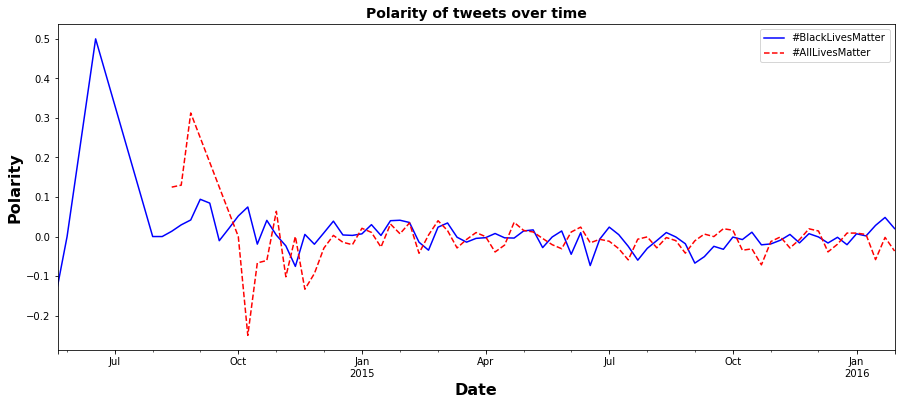

In [69]:
#Plot the polarity of tweets from 2014-05-16
#BLM
tweet_blm['date_week']=tweet_blm.date.dt.to_period("W") #Aggregate by week
ax=tweet_blm[tweet_blm['date']>'2014-05-16'].groupby('date_week').polarity.agg('mean').plot(kind='line', 
                                                                                             style='b-',
                                                                                             figsize=[15,6],
                                                                                             label='#BlackLivesMatter',
                                                                                             legend=True)
#ALLLM
tweet_alllm['date_week']=tweet_alllm.date.dt.to_period("W") #Aggregate by week
ax2=tweet_alllm[tweet_alllm['date']>'2014-05-16'].groupby('date_week').polarity.agg('mean').plot(kind='line', 
                                                                                                  style='r--',
                                                                                                  figsize=[15,6],
                                                                                                  label='#AllLivesMatter',
                                                                                                  ax=ax,
                                                                                                  legend=True)
#Labels
ax.set_title('Polarity of tweets over time',fontsize=14, fontweight='bold') #Title
ax.set_xlabel('Date',fontsize=16, fontweight='bold') #xlabel
ax.set_ylabel('Polarity',fontsize=16, fontweight='bold') #ylabel

Given the bigger standard deviations, we use the median to aggregate the subjectivity. We can observe that in the months were the protest was more viral (December and January 2015) the trends from both sides of the protest were similar. However, as time passes the tweets supporting #BlackLivesMatter tend to be more rational, while the ones against are still very emotional. Despite this, overall we can say that for this protest both of the sides tend to be very emotional.

Taking into consideration this analysis the subejctivity is probably also and indicator of the support for what the hashtag represents, that is in the case of #BlackLivesMatter hashtag can be interpreted as the higher the subjectivity, the higher the support and thus, 70% of the people who use it support the protest, while 24% are against it. Likewise, 69% of the people who tweeted with the #AllLivesMatter hashtags are against the protest, while only 26% are in favour.

After this small analysis, we can conclude that subjectivity is more informative of the protest and for the next milestone we aim to relate concrete events (kills, trials) with the emotions found in tweets and how they change depending on the type of event

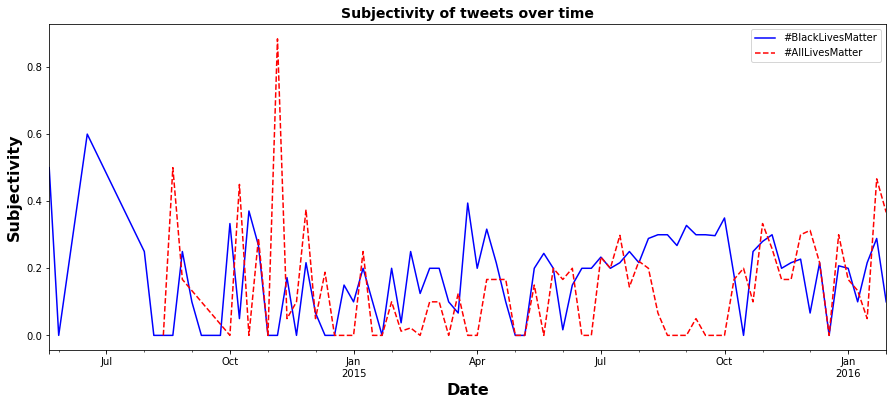

In [68]:
#Plot the number of #alllivesmatter tweets from 2014-05-16
ax=tweet_blm[tweet_blm['date']>'2014-05-16'].groupby('date_week').subj.agg('median').plot(kind='line', 
                                                                                             style='b-',
                                                                                             figsize=[15,6],
                                                                                             label='#BlackLivesMatter',
                                                                                             legend=True)

#Plot the number of #alllivesmatter tweets from 2014-05-16
ax2=tweet_alllm[tweet_alllm['date']>'2014-05-16'].groupby('date_week').subj.agg('median').plot(kind='line', 
                                                                                                  style='r--',
                                                                                                  label='#AllLivesMatter',
                                                                                                  ax=ax,
                                                                                                  legend=True)

#Labels
ax.set_title('Subjectivity of tweets over time',fontsize=14, fontweight='bold') #Title
ax.set_xlabel('Date',fontsize=16, fontweight='bold') #xlabel
ax.set_ylabel('Subjectivity',fontsize=16, fontweight='bold') #ylabel

## Using the API 
Section that illustrates how to query for tweet location, number of retweets, number of followers or other attributes in tweet object, that might deepen the insights we have, besides the data used in the cluster. 

In [76]:
#Get id's from all hashtags without repetions
list_of_ind=np.union1d(tweet_blm.index.values, tweet_alllm.index.values)

In [27]:
# enter the credentials to access the twitter api
def load_api():

    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_secret = ''
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    return tweepy.API(auth)

In [28]:
api = load_api()
#Get id's from all hashtags without repetions
list_of_ind=np.union1d(tweet_blm.index.values, tweet_alllm.index.values)
len(list_of_ind)

319116

https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-lookup limitations explain ! 

## Parallelizing the task
Since the Twitter API has some limitations of queries for each user per 15 min interval (explained at length on  https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object), we split the task of gathering additional info about the tweets. 

In [29]:
# Interval 1. Take by first name: Ada = interval 1, Isabela = interval 2, Keshav = interval 3
start_1 = 0
end_1 = 80999
start_2 = 81000
end_2 = 161999
start_3 = 162000
end_3 = 243353

In [30]:
tweets_per_file = 1000
# one batch is allowed to gave 100 twitters / query
# MODIFY ACCORDINGLY idx_by_100 for every app
idx_by_100 = list(range(start_3, end_3, 100))

In [31]:
# distribution per single user, use 3 apps
# for each app define idx_by_100 to be data_split[0]. For consistent file naming, use the intervals such that their 
# beginning value is divisible by 100 and their ending value ends in 999 or is the end (see above intervals)
data_split = np.linspace(start_2,end_2, 4)

In [ ]:
# For each batch of 1000 tweets, we write them to a json file. 
# we wait 15 minutes if the a tweepy.TweepError which should be due to the limit of queries exceeded per user. 
last_tweet = idx_by_100[-1]
for count, idx_value in enumerate(idx_by_100):
    last_tweet_batch = min((idx_value+100), last_tweet)
    range_batch = list_of_ind[idx_value : last_tweet_batch]['id'].tolist()
    filename = 'tweets_app'+ str(int(idx_value/1000))
    try:
        tweets_batch = api.statuses_lookup(range_batch)
        write_tweets(tweets_batch, filename)
        print('tweets recovered: ', len(tweets_batch), ' filename ', str(int(idx_value/1000) ))
        print('progress: ', idx_value, ' out of ', last_tweet)
    except tweepy.TweepError as e:
        print(e)
        print('exception raised, waiting 15 minutes')
        print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
        time.sleep(15*60)

tweets recovered:  65  filename  162
progress:  162000  out of  243300
tweets recovered:  67  filename  162
progress:  162100  out of  243300
tweets recovered:  63  filename  162
progress:  162200  out of  243300
tweets recovered:  64  filename  162
progress:  162300  out of  243300
tweets recovered:  71  filename  162
progress:  162400  out of  243300
tweets recovered:  70  filename  162
progress:  162500  out of  243300
tweets recovered:  76  filename  162
progress:  162600  out of  243300
tweets recovered:  80  filename  162
progress:  162700  out of  243300
tweets recovered:  71  filename  162
progress:  162800  out of  243300
tweets recovered:  68  filename  162
progress:  162900  out of  243300
tweets recovered:  77  filename  163
progress:  163000  out of  243300
tweets recovered:  66  filename  163
progress:  163100  out of  243300
tweets recovered:  74  filename  163
progress:  163200  out of  243300
tweets recovered:  82  filename  163
progress:  163300  out of  243300
tweets

tweets recovered:  59  filename  173
progress:  173600  out of  243300
tweets recovered:  73  filename  173
progress:  173700  out of  243300
tweets recovered:  69  filename  173
progress:  173800  out of  243300
tweets recovered:  75  filename  173
progress:  173900  out of  243300
tweets recovered:  72  filename  174
progress:  174000  out of  243300
tweets recovered:  66  filename  174
progress:  174100  out of  243300
tweets recovered:  68  filename  174
progress:  174200  out of  243300
tweets recovered:  65  filename  174
progress:  174300  out of  243300
tweets recovered:  67  filename  174
progress:  174400  out of  243300
tweets recovered:  76  filename  174
progress:  174500  out of  243300
tweets recovered:  67  filename  174
progress:  174600  out of  243300
tweets recovered:  61  filename  174
progress:  174700  out of  243300
tweets recovered:  75  filename  174
progress:  174800  out of  243300
tweets recovered:  78  filename  174
progress:  174900  out of  243300
tweets

tweets recovered:  77  filename  185
progress:  185200  out of  243300
tweets recovered:  74  filename  185
progress:  185300  out of  243300
tweets recovered:  70  filename  185
progress:  185400  out of  243300
tweets recovered:  79  filename  185
progress:  185500  out of  243300
tweets recovered:  82  filename  185
progress:  185600  out of  243300
tweets recovered:  59  filename  185
progress:  185700  out of  243300
tweets recovered:  72  filename  185
progress:  185800  out of  243300
tweets recovered:  78  filename  185
progress:  185900  out of  243300
tweets recovered:  71  filename  186
progress:  186000  out of  243300
tweets recovered:  64  filename  186
progress:  186100  out of  243300
tweets recovered:  68  filename  186
progress:  186200  out of  243300
tweets recovered:  77  filename  186
progress:  186300  out of  243300
tweets recovered:  77  filename  186
progress:  186400  out of  243300
tweets recovered:  62  filename  186
progress:  186500  out of  243300
tweets

tweets recovered:  68  filename  196
progress:  196800  out of  243300
tweets recovered:  72  filename  196
progress:  196900  out of  243300
tweets recovered:  80  filename  197
progress:  197000  out of  243300
tweets recovered:  70  filename  197
progress:  197100  out of  243300
tweets recovered:  71  filename  197
progress:  197200  out of  243300
tweets recovered:  73  filename  197
progress:  197300  out of  243300
tweets recovered:  54  filename  197
progress:  197400  out of  243300
tweets recovered:  56  filename  197
progress:  197500  out of  243300
tweets recovered:  58  filename  197
progress:  197600  out of  243300
tweets recovered:  68  filename  197
progress:  197700  out of  243300
tweets recovered:  59  filename  197
progress:  197800  out of  243300
tweets recovered:  62  filename  197
progress:  197900  out of  243300
tweets recovered:  56  filename  198
progress:  198000  out of  243300
tweets recovered:  62  filename  198
progress:  198100  out of  243300
tweets

tweets recovered:  73  filename  208
progress:  208400  out of  243300
tweets recovered:  69  filename  208
progress:  208500  out of  243300
tweets recovered:  75  filename  208
progress:  208600  out of  243300
tweets recovered:  76  filename  208
progress:  208700  out of  243300
tweets recovered:  73  filename  208
progress:  208800  out of  243300
tweets recovered:  68  filename  208
progress:  208900  out of  243300
tweets recovered:  79  filename  209
progress:  209000  out of  243300
tweets recovered:  73  filename  209
progress:  209100  out of  243300
tweets recovered:  68  filename  209
progress:  209200  out of  243300
tweets recovered:  69  filename  209
progress:  209300  out of  243300
tweets recovered:  67  filename  209
progress:  209400  out of  243300
tweets recovered:  68  filename  209
progress:  209500  out of  243300
tweets recovered:  72  filename  209
progress:  209600  out of  243300
tweets recovered:  70  filename  209
progress:  209700  out of  243300
tweets

tweets recovered:  57  filename  220
progress:  220000  out of  243300
tweets recovered:  56  filename  220
progress:  220100  out of  243300
tweets recovered:  71  filename  220
progress:  220200  out of  243300
tweets recovered:  66  filename  220
progress:  220300  out of  243300
tweets recovered:  63  filename  220
progress:  220400  out of  243300
tweets recovered:  67  filename  220
progress:  220500  out of  243300
tweets recovered:  75  filename  220
progress:  220600  out of  243300
tweets recovered:  79  filename  220
progress:  220700  out of  243300
tweets recovered:  70  filename  220
progress:  220800  out of  243300
tweets recovered:  72  filename  220
progress:  220900  out of  243300
tweets recovered:  68  filename  221
progress:  221000  out of  243300
tweets recovered:  53  filename  221
progress:  221100  out of  243300
tweets recovered:  35  filename  221
progress:  221200  out of  243300
tweets recovered:  38  filename  221
progress:  221300  out of  243300
tweets

tweets recovered:  61  filename  231
progress:  231600  out of  243300
tweets recovered:  69  filename  231
progress:  231700  out of  243300
tweets recovered:  69  filename  231
progress:  231800  out of  243300
tweets recovered:  72  filename  231
progress:  231900  out of  243300
tweets recovered:  66  filename  232
progress:  232000  out of  243300
tweets recovered:  65  filename  232
progress:  232100  out of  243300
tweets recovered:  63  filename  232
progress:  232200  out of  243300
tweets recovered:  52  filename  232
progress:  232300  out of  243300
tweets recovered:  59  filename  232
progress:  232400  out of  243300
tweets recovered:  65  filename  232
progress:  232500  out of  243300
tweets recovered:  70  filename  232
progress:  232600  out of  243300
tweets recovered:  59  filename  232
progress:  232700  out of  243300
tweets recovered:  67  filename  232
progress:  232800  out of  243300
tweets recovered:  63  filename  232
progress:  232900  out of  243300
tweets

tweets recovered:  69  filename  243
progress:  243200  out of  243300
[{'code': 38, 'message': 'id parameter is missing.'}]
exception raised, waiting 15 minutes
(until: 2017-11-27 01:29:03.445924 )


In [ ]:
list_of_ind = pd.DataFrame(tweet_alllm.index)
len(list_of_ind)
tweets_per_file = 1000
# one batch is allowed to gave 100 twitters / query
# MODIFY ACCORDINGLY idx_by_100 for every app
# this is an example, and this would be just if you use one APP !
idx_by_100 = list(range(0, len(list_of_ind), 100))
last_tweet = idx_by_100[-1]
for count, idx_value in enumerate(idx_by_100):
    last_tweet_batch = min((idx_value+100), last_tweet)
    range_batch = list_of_ind[idx_value : last_tweet_batch]['id'].tolist()
    filename = 'tweets_app_alllm'+ str(int(idx_value/1000))
    try:
        tweets_batch = api.statuses_lookup(range_batch)
        write_tweets(tweets_batch, filename)
        print('tweets recovered: ', len(tweets_batch), ' filename ', str(int(idx_value/1000) ))
        print('progress: ', idx_value, ' out of ', last_tweet)
    except tweepy.TweepError as e:
        print(e)
        print('exception raised, waiting 15 minutes')
        print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
        time.sleep(15*60)

### Reading tweets demo

For reading back in the tweets, we design the following procedure. 
i) we start with a dataframe with a single column representing the index of the tweets whose hashtag we are looking at, and that we obtained from the cluster. That column is the index of the dataframe. 
ii) we search through the json files collected from the api and we sequentially complete the relevant fields we are interested in in the dataframe. We dont read more than a fixed number of tweets at once because they eat up a lot of memory and we are only interested in a few fields. So we discard the tweets every once in a while.

In [18]:
tweets_api_black = []
tweet_blm_api = pd.DataFrame({'id': tweet_blm.index.values})
tweet_blm_api = tweet_blm_api.set_index('id')
tweet_blm_api.head()

""
id
357220558867410945
356945513100230657
357415765999235072
357645160827469824
357573836692135936


In [61]:
# function that given a list of tweets and a list of attributes of interest, will fill the dataframe 
def fill_in_tweets(attributes_of_interest, raw_tweets_api, df_id_api):
    for raw_tweet in raw_tweets_api:
        for k,v in attrib_of_interest.items():
            #initialisation
            if (v):
                attribute_value = raw_tweet[v[0]]
            idx = 1
            while (idx < len(v) and attribute_value):
                attribute_value = attribute_value[v[idx]]
                idx = idx +1 
            if(attribute_value):
                df_id_api.at[raw_tweet['id'], k] = attribute_value 
            else:
                df_id_api.at[raw_tweet['id'], k] = np.nan
            #print(attribute_value)
    return df_id_api
    
# function that reads all the twitters in one json file and places them in a list  
def read_twitter_json(filename, df_id_api, attributes_of_interest):
    tweets_api = []
    with open(filename, 'r') as f:
        for i,line in enumerate(f.readlines()):
            tweets_api.append(json.loads(line))
            if len(tweets_api) > 100:
                df_id_api = fill_in_tweets(attributes_of_interest, tweets_api, df_id_api)
                tweets_api = []   # empty the list, read other tweets. 
                
    return df_id_api
    

# function that locates all the relevant files which include the twitters searched fo
# and initialises the columns of interest to deafault value NAN 
def read_twitter_json_all(hashtag, df_id_api, attributes, atypes):
    condition=False
    df_id_api = df_id_api.reindex(columns = list(attributes.keys()) )
    df_id_api = df_id_api.astype(atypes)
    files_read = 0
    for filename in os.listdir('./k'):
        if(hashtag=='#blacklivesmatter'):
            condition=('tweets_app' in filename) and ('all' not in filename)
        elif(hashtag=='#alllivesmatter'):
            condition='tweets_app' in filename and 'all' in filename
        if(condition):
            print('reading {}'.format(filename))
            df_id_api = read_twitter_json('./k/' + filename, df_id_api,attributes )
            files_read = files_read + 1
    return df_id_api


In [62]:
# create a dictionary that maps attributes of interest to ways of accessing them in a twitter object. 
attrib_of_interest = {'tweet_location': ['place', 'name'], \
                      'user_location': ['user','location'], 'user_followers':['user','followers_count'], \
                     'retweets_No': ['retweet_count']}
attr_types = {'tweet_location': 'str', 'user_location': 'str', 'user_followers' : 'float64', 'retweets_No':'float64' }
tweet_blm_api =read_twitter_json_all('#blacklivesmatter', tweet_blm_api, attrib_of_interest, attr_types)

reading tweets_app162
reading tweets_app163
reading tweets_app164
reading tweets_app165
reading tweets_app166
reading tweets_app167
reading tweets_app168
reading tweets_app169
reading tweets_app170
reading tweets_app171
reading tweets_app172
reading tweets_app173
reading tweets_app174
reading tweets_app175
reading tweets_app176
reading tweets_app177
reading tweets_app178
reading tweets_app179
reading tweets_app180
reading tweets_app181
reading tweets_app182
reading tweets_app183
reading tweets_app184
reading tweets_app185
reading tweets_app186
reading tweets_app187
reading tweets_app188
reading tweets_app189
reading tweets_app190
reading tweets_app191
reading tweets_app192
reading tweets_app193
reading tweets_app194
reading tweets_app195
reading tweets_app196
reading tweets_app197
reading tweets_app198
reading tweets_app199
reading tweets_app200
reading tweets_app201
reading tweets_app202
reading tweets_app203
reading tweets_app204
reading tweets_app205
reading tweets_app206
reading tw

In [83]:
tweet_blm_api.head(11)

,tweet_location,user_location,user_followers,retweets_No
id,,,,
357220558867410945,nan,nan,NaN,NaN
356945513100230657,nan,"Baltimore, MD",2435.0,NaN
357415765999235072,nan,"Baltimore, MD",NaN,NaN
357645160827469824,nan,"Los Angeles, CA",12072.0,1.0
357573836692135936,nan,nyc. lagos.,36381.0,NaN
357340482382217217,nan,Minneapolis,1298.0,1.0
357320676606111744,nan,Cities throughout the US,14353.0,17.0
357586356404363265,nan,Turtle Island,14885.0,8.0
357309692134952964,nan,Turtle Island,NaN,NaN


In [66]:
pickle.dump(tweet_blm_api, open( "keshav.p", "wb" ))

In [40]:
with open("adaIsabela.p", 'rb') as f:
    tw = pickle.load(f)

Small analysis of features we obtained via the API. 

In [67]:
tweet_blm_api['tweet_location'].replace('nan', inplace = True)

In [79]:
sum(tweet_blm_api['tweet_location'].isnull())/ len(tweet_blm_api)

0.32651744585026687

In [80]:
tweet_blm_api['user_location'].replace('nan', inplace = True)
sum(tweet_blm_api['user_location'].isnull())/ len(tweet_blm_api)

0.083627487641409801

We can see that there is a big percentage of tweet locations that are missing (more than 30%). This is why we also included the user location, which has a smaller percentage of missing values. However, we can see that a lot are 'gibberish' (i.e.: 'In My Lane' or 'Present'). For the next milestone we are planning to look at the coordinates of the tweets (lattitude and longitute) and see if they can offer more information. However, we notice that the map we get would be having a lot of null values so we are aware there would be some bias in some conclusions/visualisations.

In [70]:
tweet_blm_api_2 = tweet_blm_api.copy(deep=True)
tweet_blm_api_2['date'] = tweet_blm['date']

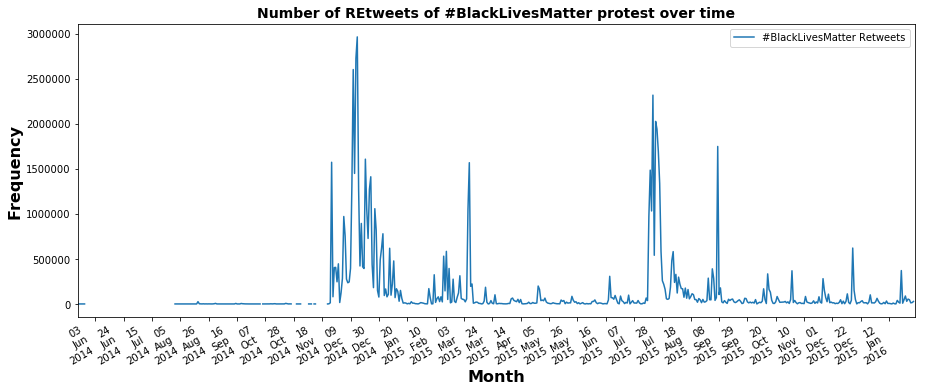

In [89]:
#Plot the number of tweets from 2014-05-16 (show the peak better)
#BLM
ax=tweet_blm_api_2[tweet_blm_api_2['date']>'2014-05-16'].groupby('date').retweets_No.agg('sum').plot(kind='line', 
                                                                                     figsize=[15,6], 
                                                                                     label='#BlackLivesMatter Retweets',
                                                                                     legend=True)

#Labels
ax.set_title('Number of REtweets of #BlackLivesMatter protest over time',fontsize=14, fontweight='bold') #Title
ax.set_xlabel('Month',fontsize=16, fontweight='bold') #xlabel
ax.set_ylabel('Frequency',fontsize=16, fontweight='bold') #ylabel
#Change ticks parameters
ax.tick_params(labelsize=10) #Size
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=3)) #Position
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%b\n%Y')) #Format

We do a similar analysis as we did previously with the number of tweets on BLM with the number of retweets. As expected. We se the numbers follow a very similar trend (we did not plot the number of tweets due to them being in different scales). Therefore, we can see that both number of tweets and retweets are a good measure of impact of a protest